# Lake model continued

In the previous week you used the lake problem as a means of getting aquinted with the workbench. In this assignment we will continue with the lake problem, focussing explicitly on using it for open exploration. You can use the second part of [this tutoria]https://emaworkbench.readthedocs.io/en/latest/indepth_tutorial/open-exploration.html) for help.

**It is paramount that you are using the lake problem with 100 decision variables, rather than the one found on the website with the seperate anthropogenic release decision**

## Apply sensitivity analysis
There is substantial support in the ema_workbench for global sensitivity. For this, the workbench relies on [SALib](https://salib.readthedocs.io/en/latest/) and feature scoring which is a machine learning alternative for global sensitivity analysis. 

1. As a start, generate a release policy without any release *(hint: use a Policy instance)*
2. use sobol sampling with the no release policy, and set n to 10.000
3. calculate sobol indices for max_P and reliability based on 10, 100, 1000, and 10.000 experiments. *(hint: sobol is a deterministic sequence, so you can slice results from the data generated in stap 2)*

In [1]:
from lakemodel_function import lake_problem

from ema_workbench import (Model, RealParameter, ScalarOutcome, Constant)

#instantiate the model
lake_model = Model('lakeproblem', function=lake_problem)
lake_model.time_horizon = 100 # used to specify the number of timesteps

#specify uncertainties
lake_model.uncertainties = [RealParameter('mean', 0.01, 0.05),
                            RealParameter('stdev', 0.001, 0.005),
                            RealParameter('b', 0.1, 0.45),
                            RealParameter('q', 2.0, 4.5),
                            RealParameter('delta', 0.93, 0.99)]

# set levers, one for each time step
lake_model.levers = [RealParameter(str(i), 0, 0.1) for i in 
                     range(lake_model.time_horizon)] # we use time_horizon here

#specify outcomes 
lake_model.outcomes = [ScalarOutcome('max_P'),
                       ScalarOutcome('utility'),
                       ScalarOutcome('inertia'),
                       ScalarOutcome('reliability')]

In [2]:
from ema_workbench import MultiprocessingEvaluator, ema_logging, Policy
from ema_workbench.em_framework.evaluators import SOBOL

ema_logging.log_to_stderr(ema_logging.INFO)

no_release = Policy("norelease", **{l.name:0 for l in lake_model.levers})

n_scenarios = int(1e4)

with MultiprocessingEvaluator(lake_model) as evaluator:
    experiments, outcomes = evaluator.perform_experiments(n_scenarios, policies=[no_release],
                                                          uncertainty_sampling=SOBOL)



[MainProcess/INFO] pool started
[MainProcess/INFO] performing 120000 scenarios * 1 policies * 1 model(s) = 120000 experiments
[MainProcess/INFO] 12000 cases completed
[MainProcess/INFO] 24000 cases completed
[MainProcess/INFO] 36000 cases completed
[MainProcess/INFO] 48000 cases completed
[MainProcess/INFO] 60000 cases completed
[MainProcess/INFO] 72000 cases completed
[MainProcess/INFO] 84000 cases completed
[MainProcess/INFO] 96000 cases completed
[MainProcess/INFO] 108000 cases completed
[MainProcess/INFO] 120000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [5]:
from SALib.analyze import sobol
from ema_workbench.em_framework import get_SALib_problem

ooi = 'max_P'
data = outcomes[ooi]
problem = get_SALib_problem(lake_model.uncertainties)

SI = []
for i in [1e1, 1e2, 1e3, 1e4]:
    i = int(i) * (2*len(lake_model.uncertainties) + 2) 
    
    y = data[0:i]
    si = sobol.analyze(problem, y)
    SI.append(si)


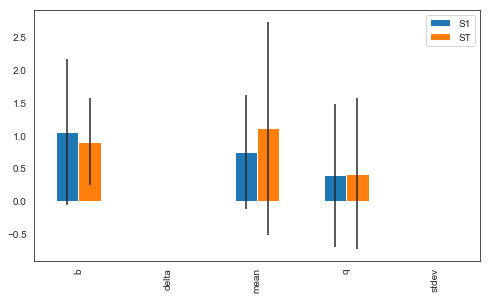

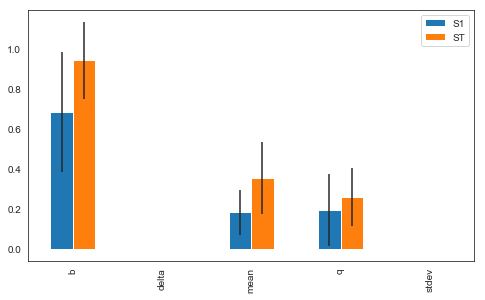

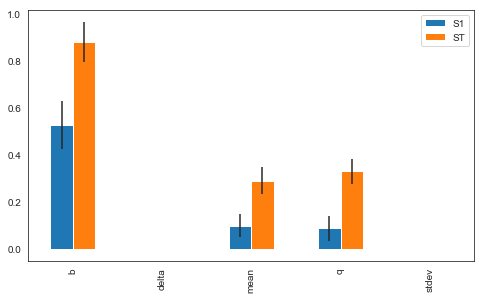

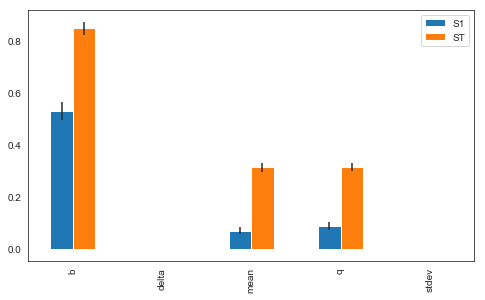

In [6]:
def plot_si(Si):

    Si_filter = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}
    Si_df = pd.DataFrame(Si_filter, index=problem['names'])

    sns.set_style('white')
    fig, ax = plt.subplots(1)

    indices = Si_df[['S1','ST']]
    err = Si_df[['S1_conf','ST_conf']]

    indices.plot.bar(yerr=err.values.T,ax=ax)
    fig.set_size_inches(8,6)
    fig.subplots_adjust(bottom=0.3)


for Si in SI:
    plot_si(Si)
plt.show()